# Recurrent Neural Networks Models
In this notebook, we show an example of how RNNs can be used with darts.
If you are new to darts, we recommend you first follow the [quick start](https://unit8co.github.io/darts/quickstart/00-quickstart.html) notebook.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.metrics import mape, rmse
from darts.models import BlockRNNModel, ExponentialSmoothing, RNNModel
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

## Recurrent Models

Darts includes two recurrent forecasting model classes: `RNNModel` and `BlockRNNModel`. 

`RNNModel` is fully recurrent in the sense that, at prediction time, an output is computed using these inputs:

- the previous target value, which will be set to the last known target value for the first prediction,
  and for all other predictions it will be set to the previous prediction
- the previous hidden state
- the current covariates (if the model was trained with covariates)

A prediction with forecasting horizon `n` thus is created in `n` iterations of `RNNModel` predictions and requires `n` future covariates to be known. This model is suited for forecasting problems where the target series is highly dependent on covariates that are known in advance.

`BlockRNNModel` has a recurrent encoder stage, which encodes its input, and a fully-connected neural network decoder stage, which produces a prediction of length `output_chunk_length` based on the last hidden state of the encoder stage. Consequently, this model produces 'blocks' of forecasts and is restricted to looking at covariates with the same time index as the input target series.

## Air Passenger Example
This is a data set that is highly dependent on covariates. Knowing the month tells us a lot about the seasonal component, whereas the year determines the effect of the trend component. Both of these covariates are known in the future, and thus the `RNNModel` class is the preferred choice for this problem.

In [4]:
# Read data:
series = AirPassengersDataset().load()

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("19590101"))

Let's train an LSTM neural net. For using vanilla RNN or GRU instead, replace `'LSTM'` by `'RNN'` or `'GRU'`, respectively.

In [5]:
my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)

In what follows, we can just provide the whole `covariates` series as `future_covariates` argument to the model; the model will slice these covariates and use only what it needs in order to train on forecasting the target `train_transformed`:

In [ ]:
my_model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

### Look at predictions on the validation set
Use the "current" model - i.e., the model at the end of the training procedure:

Predicting: 0it [00:00, ?it/s]

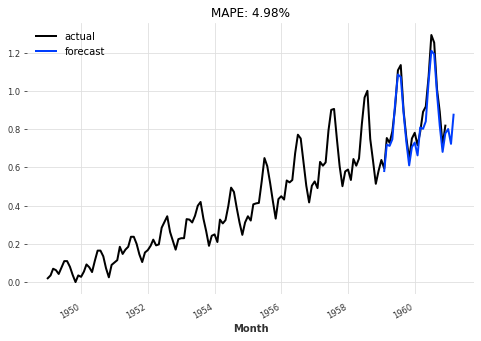

In [7]:
def eval_model(model):
    pred_series = model.predict(n=26, future_covariates=covariates)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title(f"MAPE: {mape(pred_series, val_transformed):.2f}%")
    plt.legend()


eval_model(my_model)

Use the best model obtained over training, according to validation loss:

Predicting: 0it [00:00, ?it/s]

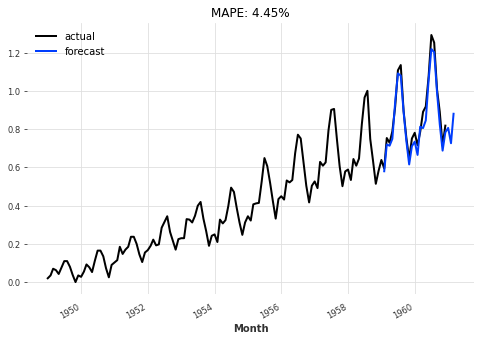

In [8]:
best_model = RNNModel.load_from_checkpoint(model_name="Air_RNN", best=True)
eval_model(best_model)

### Backtesting
Let's backtest our `RNN` model, to see how it performs at a forecast horizon of 6 months:

In [9]:
backtest_series = my_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates,
    start=pd.Timestamp("19590101"),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

  0%|          | 0/19 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

MAPE: 2.71%


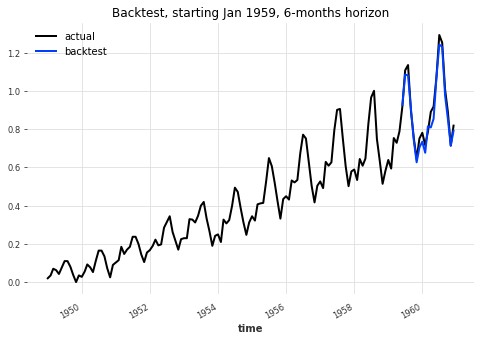

In [10]:
plt.figure(figsize=(8, 5))
series_transformed.plot(label="actual")
backtest_series.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting Jan 1959, 6-months horizon")
print(
    "MAPE: {:.2f}%".format(
        mape(
            transformer.inverse_transform(series_transformed),
            transformer.inverse_transform(backtest_series),
        )
    )
)

## Monthly sunspots
Let's now try a more challenging time series; that of the monthly number of sunspots since 1749. First, we build the time series from the data, and check its periodicity.

(True, np.int64(125))

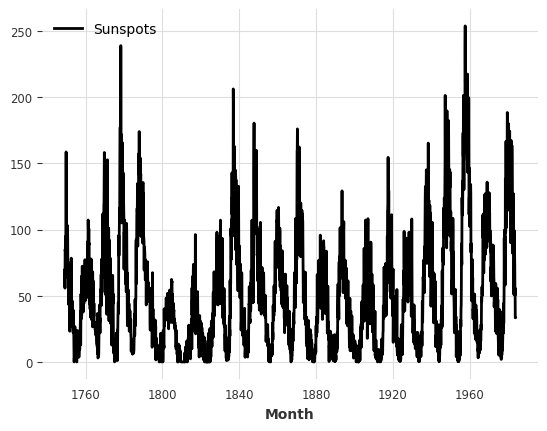

In [14]:
series_sunspot = SunspotsDataset().load()

series_sunspot.plot()
check_seasonality(series_sunspot, max_lag=240)

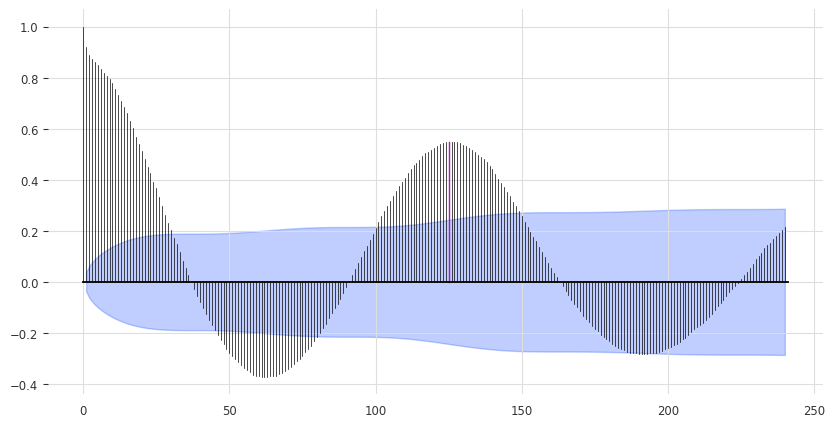

In [15]:
plot_acf(series_sunspot, 125, max_lag=240)  # ~11 years seasonality

In [16]:
train_sp, val_sp = series_sunspot.split_after(pd.Timestamp("19401001"))

transformer_sunspot = Scaler()
train_sp_transformed = transformer_sunspot.fit_transform(train_sp)
val_sp_transformed = transformer_sunspot.transform(val_sp)
series_sp_transformed = transformer_sunspot.transform(series_sunspot)

In [ ]:
my_model_sun = BlockRNNModel(
    model="GRU",
    input_chunk_length=125,
    output_chunk_length=36,
    hidden_dim=10,
    n_rnn_layers=1,
    batch_size=32,
    n_epochs=100,
    dropout=0.1,
    model_name="sun_GRU",
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
)

my_model_sun.fit(train_sp_transformed, val_series=val_sp_transformed, verbose=True)

To evaluate our model, we will simulate historic forecasting with a forecasting horizon of 3 years across the validation set. To speed things up, we will only look at every 10th forecast. For the sake of comparison, let's also fit an exponential smoothing model.

In [15]:
# Compute the backtest predictions with the two models
pred_series = my_model_sun.historical_forecasts(
    series_sp_transformed,
    start=pd.Timestamp("19401001"),
    forecast_horizon=36,
    stride=10,
    retrain=False,
    last_points_only=True,
    verbose=True,
)

pred_series_ets = ExponentialSmoothing(seasonal_periods=120).historical_forecasts(
    series_sp_transformed,
    start=pd.Timestamp("19401001"),
    forecast_horizon=36,
    stride=10,
    retrain=True,
    last_points_only=True,
    verbose=True,
)

  0%|          | 0/49 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

RNN MAPE: 73.19010018398568
ETS MAPE: 116.63584309419007


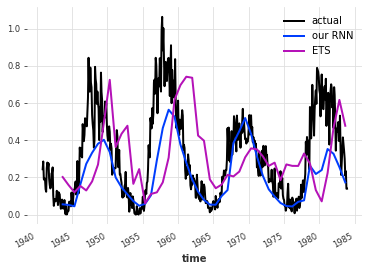

In [16]:
val_sp_transformed.plot(label="actual")
pred_series.plot(label="our RNN")
pred_series_ets.plot(label="ETS")
plt.legend()
print("RNN MAPE:", mape(pred_series, val_sp_transformed))
print("ETS MAPE:", mape(pred_series_ets, val_sp_transformed))

## Electricity Consumption of the city of Zürich

This example is meant to compare the use of future covariates, and the way they're integrated.

In [4]:
import numpy as np

from darts.datasets import ElectricityConsumptionZurichDataset

In [5]:
data = ElectricityConsumptionZurichDataset().load().astype(np.float32)
series = data["Value_NE5"].resample("1h", method="sum")
covariates = data["T [°C]"].resample("1h", method="mean")

print(series.shape)
print(covariates.shape)

(67177, 1, 1)
(67177, 1, 1)


<Axes: xlabel='Timestamp'>

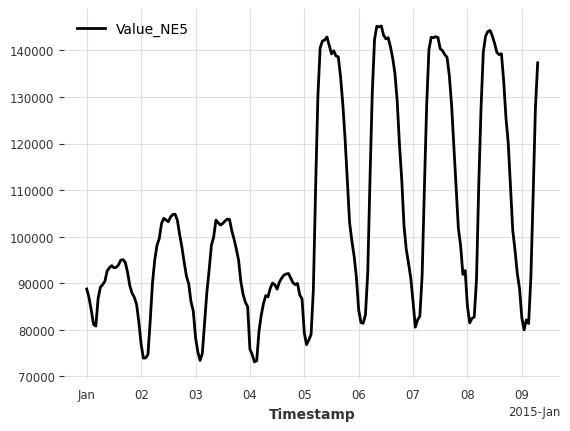

In [6]:
series[:200].plot()

In [7]:
train_data, test_data = series.split_after(0.9)
train_data, val_data = train_data.split_after(0.8)

transformer = Scaler()
train_data_transformed = transformer.fit_transform(train_data)
val_data_transformed = transformer.transform(val_data)
test_data_transformed = transformer.transform(test_data)
series_data_transformed = transformer.transform(series)

covariates = Scaler().fit_transform(covariates)

In [9]:
model_elec_zurich_future_concat = BlockRNNModel(
    model="RNN",
    input_chunk_length=48,
    output_chunk_length=24,
    model_name="zurich_elec_rnn_future_concat",
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    add_encoders={"cyclic": {"future": ["month", "dayofweek", "hour"]}},
    future_cov_integ="concat",
)

model_elec_zurich_future_concat.fit(
    train_data_transformed,
    val_series=val_data_transformed,
    future_covariates=covariates,
    val_future_covariates=covariates,
    verbose=True,
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=RNN, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, activation=ReLU, future_cov_integ=concat, input_chunk_length=48, output_chunk_length=24, model_name=zurich_elec_rnn_future_concat, optimizer_kwargs={'lr': 0.001}, save_checkpoints=True, log_tensorboard=True, random_state=42, force_reset=True, add_encoders={'cyclic': {'future': ['month', 'dayofweek', 'hour']}})

In [ ]:
model_elec_zurich_future_concat = BlockRNNModel(
    model="RNN",
    input_chunk_length=48,
    output_chunk_length=24,
    model_name="zurich_elec_rnn_future_concat",
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    add_encoders={"cyclic": {"future": ["month", "dayofweek", "hour"]}},
    future_cov_integ="concat",
)

model_elec_zurich_future_concat.fit(
    train_data_transformed,
    val_series=val_data_transformed,
    future_covariates=covariates,
    val_future_covariates=covariates,
    verbose=True,
)

In [ ]:
model_elec_zurich_future_nf = BlockRNNModel(
    model="RNN",
    input_chunk_length=48,
    output_chunk_length=24,
    model_name="zurich_elec_rnn_future_nf",
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    add_encoders={"cyclic": {"future": ["month", "dayofweek", "hour"]}},
    future_cov_integ="nf",
)

model_elec_zurich_future_nf.fit(
    train_data_transformed,
    val_series=val_data_transformed,
    future_covariates=covariates,
    val_future_covariates=covariates,
    verbose=True,
)

In [9]:
model_elec_zurich_future_add = BlockRNNModel(
    model="RNN",
    input_chunk_length=48,
    output_chunk_length=24,
    model_name="zurich_elec_rnn_future_add",
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    add_encoders={"cyclic": {"future": ["month", "dayofweek", "hour"]}},
    future_cov_integ="add",
)

model_elec_zurich_future_add.fit(
    train_data_transformed,
    val_series=val_data_transformed,
    future_covariates=covariates,
    val_future_covariates=covariates,
    verbose=True,
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

NameError: name 'exit' is not defined

In [8]:
model_elec_zurich_past = BlockRNNModel(
    model="RNN",
    input_chunk_length=48,
    output_chunk_length=24,
    model_name="zurich_elec_rnn",
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    add_encoders={"cyclic": {"past": ["month", "dayofweek", "hour"]}},
)

model_elec_zurich_past.fit(
    train_data_transformed,
    val_series=val_data_transformed,
    past_covariates=covariates,
    val_past_covariates=covariates,
    verbose=True,
)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=RNN, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, activation=ReLU, future_cov_integ=None, input_chunk_length=48, output_chunk_length=24, model_name=zurich_elec_rnn, optimizer_kwargs={'lr': 0.001}, save_checkpoints=True, log_tensorboard=True, random_state=42, force_reset=True, add_encoders={'cyclic': {'past': ['month', 'dayofweek', 'hour']}})

In [10]:
# model_concat = BlockRNNModel.load_from_checkpoint(
#     model_name="zurich_elec_rnn_future_concat", best=True
# )
model_concat = BlockRNNModel.load_from_checkpoint(
    model_name="zurich_elec_rnn_future_concat", best=True
)
model_past = BlockRNNModel.load_from_checkpoint(model_name="zurich_elec_rnn", best=True)
model_nf = BlockRNNModel.load_from_checkpoint(
    model_name="zurich_elec_rnn_future_nf", best=True
)

In [11]:
# pred_series_add = model_add.historical_forecasts(
#     series_data_transformed,
#     start=0.9,
#     forecast_horizon=24,
#     stride=24,
#     retrain=False,
#     last_points_only=False,
#     verbose=True,
# )

pred_series_nf = model_nf.historical_forecasts(
    series_data_transformed,
    start=0.9,
    forecast_horizon=24,
    stride=24,
    retrain=False,
    last_points_only=False,
    verbose=True,
)

pred_series_concat = model_concat.historical_forecasts(
    series_data_transformed,
    start=0.9,
    forecast_horizon=24,
    stride=24,
    retrain=False,
    last_points_only=False,
    verbose=True,
)

pred_series_past = model_past.historical_forecasts(
    series_data_transformed,
    start=0.9,
    forecast_horizon=24,
    stride=24,
    retrain=False,
    last_points_only=False,
    verbose=True,
)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions shape : torch.Size([32, 48, 25]) torch.Size([32, 24, 7])
Predictions shape : torch.Size([32, 48, 25]) torch.Size([32, 24, 7])
Predictions shape : torch.Size([32, 48, 25]) torch.Size([32, 24, 7])
Predictions shape : torch.Size([32, 48, 25]) torch.Size([32, 24, 7])
Predictions shape : torch.Size([32, 48, 25]) torch.Size([32, 24, 7])
Predictions shape : torch.Size([32, 48, 25]) torch.Size([32, 24, 7])
Predictions shape : torch.Size([32, 48, 25]) torch.Size([32, 24, 7])
Predictions shape : torch.Size([32, 48, 25]) torch.Size([32, 24, 7])
Predictions shape : torch.Size([23, 48, 25]) torch.Size([23, 24, 7])


Generating TimeSeries:   0%|          | 0/279 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Generating TimeSeries:   0%|          | 0/279 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Generating TimeSeries:   0%|          | 0/279 [00:00<?, ?it/s]

In [12]:
from darts.timeseries import concatenate

# pred_series_concat = concatenate(pred_series_concat)
pred_series_nf = concatenate(pred_series_nf)
pred_series_past = concatenate(pred_series_past)
pred_series_concat = concatenate(pred_series_concat)

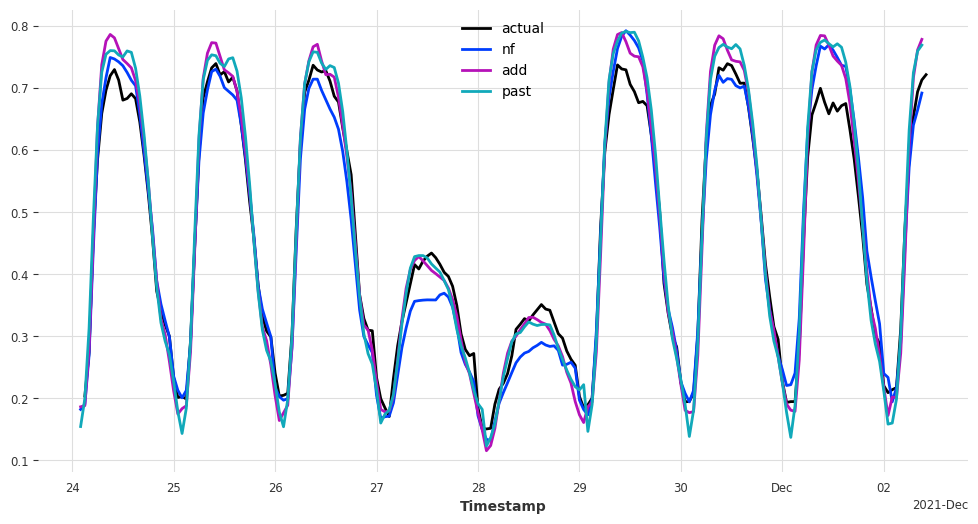

RNN NF MAPE: 9.673933
RNN ADD MAPE: 11.034717
RNN PAST MAPE: 10.708387


In [13]:
import matplotlib.pyplot as plt

test_data_transformed = transformer.transform(test_data)
plt.figure(figsize=(12, 6))
test_data_transformed[:200].plot(label="actual")
pred_series_nf[:200].plot(label="nf")
pred_series_concat[:200].plot(label="add")
pred_series_past[:200].plot(label="past")
plt.legend()
plt.grid(True)
plt.show()
print("RNN NF MAPE:", mape(pred_series_nf, test_data_transformed))
print("RNN CONCAT MAPE:", mape(pred_series_concat, test_data_transformed))
print("RNN PAST MAPE:", mape(pred_series_past, test_data_transformed))

In [26]:
import os

import numpy as np
import pandas as pd

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from darts.datasets import IceCreamHeaterDataset

series_ice_heater = IceCreamHeaterDataset().load().astype(np.float32)

ice_series = series_ice_heater["ice cream"]

forecast_horizon_ice = 12
training_cutoff_ice = ice_series.time_index[-(2 * forecast_horizon_ice)]

train_ice, val_ice = ice_series.split_before(training_cutoff_ice)
transformer_ice = Scaler()
train_ice_transformed = transformer_ice.fit_transform(train_ice)
val_ice_transformed = transformer_ice.transform(val_ice)
series_ice_transformed = transformer_ice.transform(ice_series)

future_cov = series_ice_heater["heater"]

cov_heat_train, cov_heat_val = future_cov.split_before(training_cutoff_ice)
transformer_heat = Scaler()
transformer_heat.fit(cov_heat_train)
covariates_heat_transformed = transformer_heat.transform(future_cov)

input_chunk_length_ice = 36

In [52]:
model_ice_heater_future_concat = BlockRNNModel(
    model="RNN",
    input_chunk_length=input_chunk_length_ice,
    output_chunk_length=forecast_horizon_ice,
    model_name="ice_heater_future_concat",
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    log_tensorboard=True,
    n_epochs=1000,
    random_state=42,
    force_reset=True,
    add_encoders={"cyclic": {"future": ["month"]}},
    future_cov_integ="concat",
)

model_ice_heater_future_concat.fit(
    train_ice_transformed,
    future_covariates=covariates_heat_transformed,
    verbose=True,
)

Training: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=RNN, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, activation=ReLU, future_cov_integ=concat, input_chunk_length=36, output_chunk_length=12, model_name=ice_heater_future_concat, optimizer_kwargs={'lr': 0.001}, save_checkpoints=True, log_tensorboard=True, n_epochs=1000, random_state=42, force_reset=True, add_encoders={'cyclic': {'future': ['month']}})

In [48]:
model_ice_heater_future_add = BlockRNNModel(
    model="RNN",
    input_chunk_length=input_chunk_length_ice,
    output_chunk_length=forecast_horizon_ice,
    model_name="ice_heater_future_add",
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    log_tensorboard=True,
    n_epochs=500,
    random_state=42,
    force_reset=True,
    add_encoders={"cyclic": {"future": ["month"]}},
    future_cov_integ="add",
)

model_ice_heater_future_add.fit(
    train_ice_transformed,
    future_covariates=covariates_heat_transformed,
    verbose=True,
)

Training: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=RNN, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, activation=ReLU, future_cov_integ=add, input_chunk_length=36, output_chunk_length=12, model_name=ice_heater_future_add, optimizer_kwargs={'lr': 0.001}, save_checkpoints=True, log_tensorboard=True, n_epochs=500, random_state=42, force_reset=True, add_encoders={'cyclic': {'future': ['month']}})

In [49]:
model_ice_heater_future_nf = BlockRNNModel(
    model="RNN",
    input_chunk_length=input_chunk_length_ice,
    output_chunk_length=forecast_horizon_ice,
    model_name="ice_heater_future_nf",
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    log_tensorboard=True,
    n_epochs=500,
    random_state=42,
    force_reset=True,
    add_encoders={"cyclic": {"future": ["month"]}},
    future_cov_integ="nf",
)

model_ice_heater_future_nf.fit(
    train_ice_transformed,
    future_covariates=covariates_heat_transformed,
    verbose=True,
)

Training: |          | 0/? [00:00<?, ?it/s]

Predictions shape : torch.Size([32, 36, 25]) torch.Size([32, 12, 3])
Predictions shape : torch.Size([32, 36, 25]) torch.Size([32, 12, 3])
Predictions shape : torch.Size([32, 36, 25]) torch.Size([32, 12, 3])
Predictions shape : torch.Size([31, 36, 25]) torch.Size([31, 12, 3])
Predictions shape : torch.Size([32, 36, 25]) torch.Size([32, 12, 3])
Predictions shape : torch.Size([32, 36, 25]) torch.Size([32, 12, 3])
Predictions shape : torch.Size([32, 36, 25]) torch.Size([32, 12, 3])
Predictions shape : torch.Size([31, 36, 25]) torch.Size([31, 12, 3])
Predictions shape : torch.Size([32, 36, 25]) torch.Size([32, 12, 3])
Predictions shape : torch.Size([32, 36, 25]) torch.Size([32, 12, 3])
Predictions shape : torch.Size([32, 36, 25]) torch.Size([32, 12, 3])
Predictions shape : torch.Size([31, 36, 25]) torch.Size([31, 12, 3])
Predictions shape : torch.Size([32, 36, 25]) torch.Size([32, 12, 3])
Predictions shape : torch.Size([32, 36, 25]) torch.Size([32, 12, 3])
Predictions shape : torch.Size([32

BlockRNNModel(output_chunk_shift=0, model=RNN, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, activation=ReLU, future_cov_integ=nf, input_chunk_length=36, output_chunk_length=12, model_name=ice_heater_future_nf, optimizer_kwargs={'lr': 0.001}, save_checkpoints=True, log_tensorboard=True, n_epochs=500, random_state=42, force_reset=True, add_encoders={'cyclic': {'future': ['month']}})

In [65]:
model_ice_heater_past = BlockRNNModel(
    model="RNN",
    input_chunk_length=input_chunk_length_ice,
    output_chunk_length=forecast_horizon_ice,
    model_name="ice_heater_past",
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    log_tensorboard=True,
    n_epochs=500,
    random_state=42,
    force_reset=True,
    add_encoders={"cyclic": {"past": ["month"]}},
)

model_ice_heater_past.fit(
    train_ice_transformed,
    past_covariates=covariates_heat_transformed,
    verbose=True,
)

Training: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=RNN, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, activation=ReLU, future_cov_integ=None, input_chunk_length=36, output_chunk_length=12, model_name=ice_heater_past, optimizer_kwargs={'lr': 0.001}, save_checkpoints=True, log_tensorboard=True, n_epochs=500, random_state=42, force_reset=True, add_encoders={'cyclic': {'past': ['month']}})

In [59]:
import os

curr_dir = os.path.abspath("..")

model_ice_heater_past = BlockRNNModel.load_from_checkpoint(
    model_name="ice_heater_past", best=False
)
model_ice_heater_future_concat = BlockRNNModel.load_from_checkpoint(
    model_name="ice_heater_future_concat", best=False
)
model_ice_heater_future_add = BlockRNNModel.load_from_checkpoint(
    model_name="ice_heater_future_add", best=False
)
model_ice_heater_future_nf = BlockRNNModel.load_from_checkpoint(
    model_name="ice_heater_future_nf", best=False
)

backtest_series_ice_past = model_ice_heater_past.historical_forecasts(
    series_ice_transformed,
    start=training_cutoff_ice,
    forecast_horizon=forecast_horizon_ice,
    stride=forecast_horizon_ice,
    retrain=False,
    last_points_only=False,
    verbose=True,
)

backtest_series_ice_concat = model_ice_heater_future_concat.historical_forecasts(
    series_ice_transformed,
    start=training_cutoff_ice,
    forecast_horizon=forecast_horizon_ice,
    stride=forecast_horizon_ice,
    retrain=False,
    last_points_only=False,
    verbose=True,
)

backtest_series_ice_add = model_ice_heater_future_add.historical_forecasts(
    series_ice_transformed,
    start=training_cutoff_ice,
    forecast_horizon=forecast_horizon_ice,
    stride=forecast_horizon_ice,
    retrain=False,
    last_points_only=False,
    verbose=True,
)

backtest_series_ice_nf = model_ice_heater_future_nf.historical_forecasts(
    series_ice_transformed,
    start=training_cutoff_ice,
    forecast_horizon=forecast_horizon_ice,
    stride=forecast_horizon_ice,
    retrain=False,
    last_points_only=False,
    verbose=True,
)

backtest_series_ice_past = concatenate(backtest_series_ice_past)
backtest_series_ice_concat = concatenate(backtest_series_ice_concat)
backtest_series_ice_add = concatenate(backtest_series_ice_add)
backtest_series_ice_nf = concatenate(backtest_series_ice_nf)

Predicting: |          | 0/? [00:00<?, ?it/s]

Generating TimeSeries:   0%|          | 0/2 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Generating TimeSeries:   0%|          | 0/2 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Generating TimeSeries:   0%|          | 0/2 [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions shape : torch.Size([2, 36, 25]) torch.Size([2, 12, 3])


Generating TimeSeries:   0%|          | 0/2 [00:00<?, ?it/s]

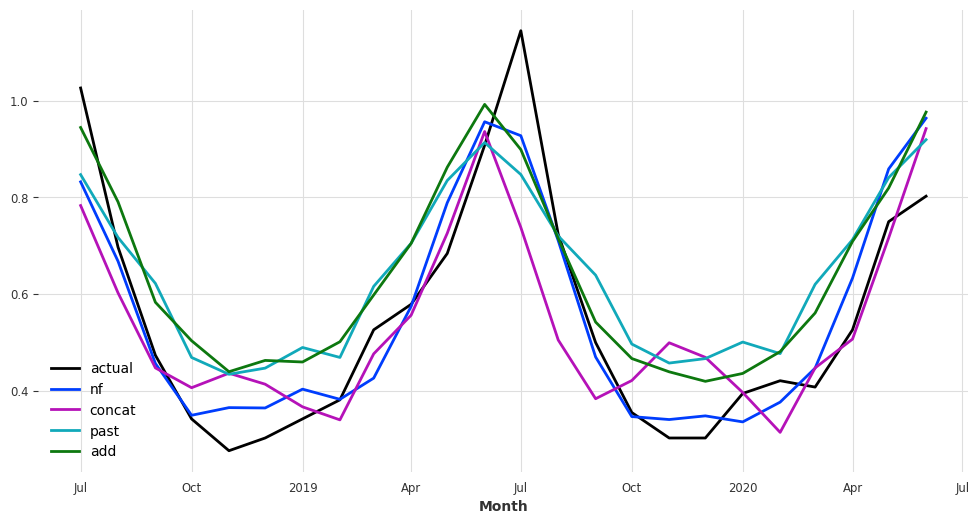

RNN NF MAPE: 11.485044
RNN CONCAT MAPE: 19.172752
RNN PAST MAPE: 21.471334
RNN ADD MAPE: 19.684736


In [60]:
plt.figure(figsize=(12, 6))
val_ice_transformed.plot(label="actual")
backtest_series_ice_nf.plot(label="nf")
backtest_series_ice_concat.plot(label="concat")
backtest_series_ice_past.plot(label="past")
backtest_series_ice_add.plot(label="add")
plt.legend()
plt.grid(True)
plt.show()
print("RNN NF MAPE:", mape(backtest_series_ice_nf, val_ice_transformed))
print("RNN CONCAT MAPE:", mape(backtest_series_ice_concat, val_ice_transformed))
print("RNN PAST MAPE:", mape(backtest_series_ice_past, val_ice_transformed))
print("RNN ADD MAPE:", mape(backtest_series_ice_add, val_ice_transformed))

In [63]:
print("RNN NF RMSE:", rmse(backtest_series_ice_nf, val_ice_transformed))
print("RNN CONCAT RMSE:", rmse(backtest_series_ice_concat, val_ice_transformed))
print("RNN PAST RMSE:", rmse(backtest_series_ice_past, val_ice_transformed))
print("RNN ADD RMSE:", rmse(backtest_series_ice_add, val_ice_transformed))

RNN NF RMSE: 0.08800481
RNN CONCAT RMSE: 0.13699228
RNN PAST RMSE: 0.14257853
RNN ADD RMSE: 0.12887587


In [4]:
from darts.datasets import ETTh1Dataset

trafo = ETTh1Dataset().load().astype("float32")
train, temp = trafo.split_after(0.6)
val, test = temp.split_after(0.5)

scaler = Scaler()
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

In [5]:
input_chunk_length_etth1 = 7 * 24
output_chunk_length_etth1 = 24

In [22]:
model1 = BlockRNNModel(
    model="RNN",
    input_chunk_length=input_chunk_length_etth1,
    output_chunk_length=output_chunk_length_etth1,
    model_name="etth1_old",
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
)

model2 = BlockRNNModel(
    model="RNN",
    input_chunk_length=input_chunk_length_etth1,
    output_chunk_length=output_chunk_length_etth1,
    model_name="etth1_nf",
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    future_cov_integ="nf",
)

model3 = BlockRNNModel(
    model="RNN",
    input_chunk_length=input_chunk_length_etth1,
    output_chunk_length=output_chunk_length_etth1,
    model_name="etth1_nf_with_encoders",
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    future_cov_integ="nf",
    add_encoders={"cyclic": {"future": ["hour", "dayofweek", "month"]}},
)

models = {
    "etth1_old": model1,
    "etth1_nf": model2,
    "etth1_nf_with_encoders": model3,
}

In [ ]:
# for model_name, model in models.items():
#     model.fit(
#         series=train,
#         val_series=val,
#         verbose=True,
#     )

In [23]:
def historical_forecasts(model_):
    hfc = model_.historical_forecasts(
        series=test,
        forecast_horizon=output_chunk_length_etth1,
        stride=output_chunk_length_etth1,
        last_points_only=False,
        retrain=False,
        verbose=True,
    )

    hfc = concatenate(hfc)

    return scaler.inverse_transform(hfc)

Generating historical forecasts for etth1_old...


Predicting: |          | 0/? [00:00<?, ?it/s]

Generating TimeSeries:   0%|          | 0/138 [00:00<?, ?it/s]

Generating historical forecasts for etth1_nf...


Predicting: |          | 0/? [00:00<?, ?it/s]

Generating TimeSeries:   0%|          | 0/138 [00:00<?, ?it/s]

Generating historical forecasts for etth1_nf_with_encoders...


Predicting: |          | 0/? [00:00<?, ?it/s]

Generating TimeSeries:   0%|          | 0/138 [00:00<?, ?it/s]

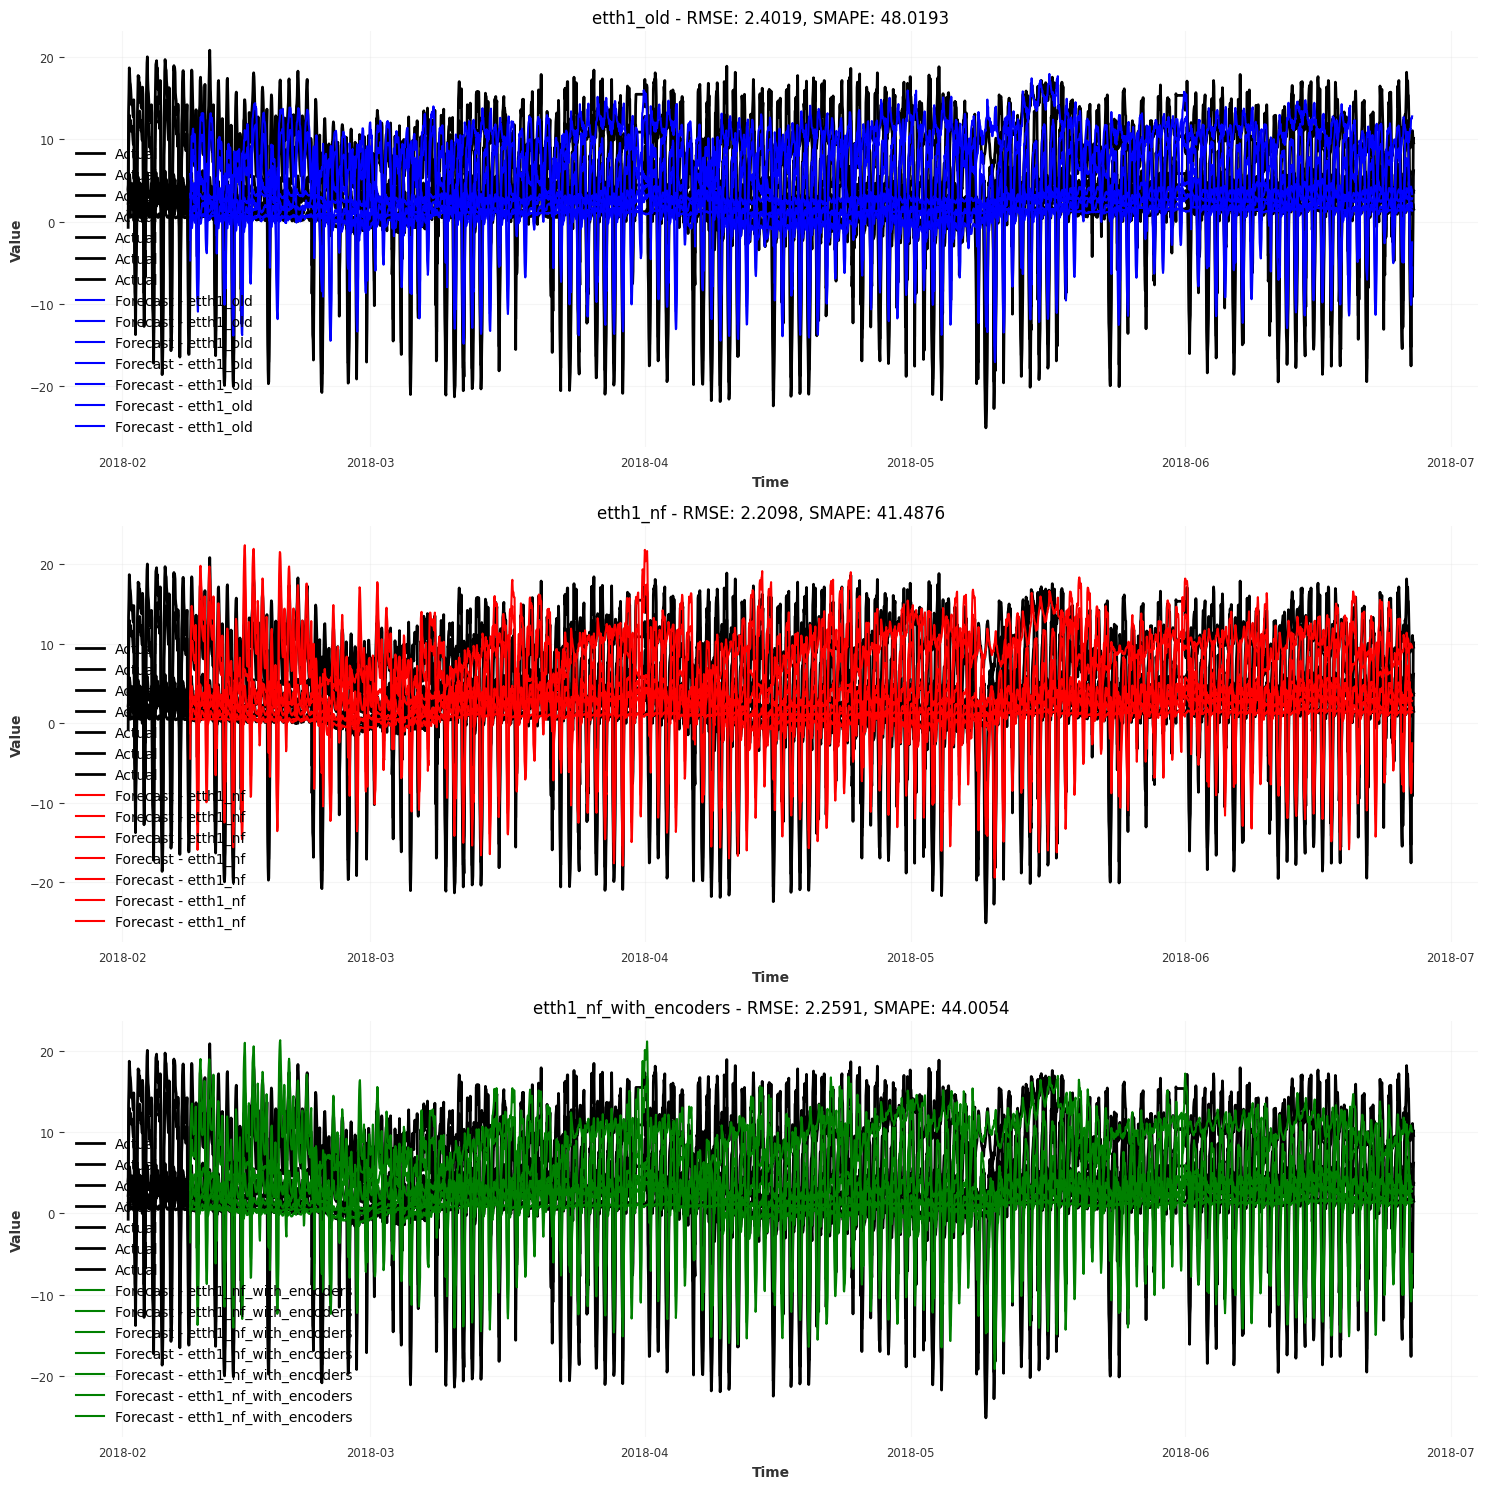


METRICS SUMMARY
etth1_old:
  RMSE: 2.401876
  SMAPE: 48.019341
------------------------------
etth1_nf:
  RMSE: 2.209753
  SMAPE: 41.487610
------------------------------
etth1_nf_with_encoders:
  RMSE: 2.259139
  SMAPE: 44.005394
------------------------------


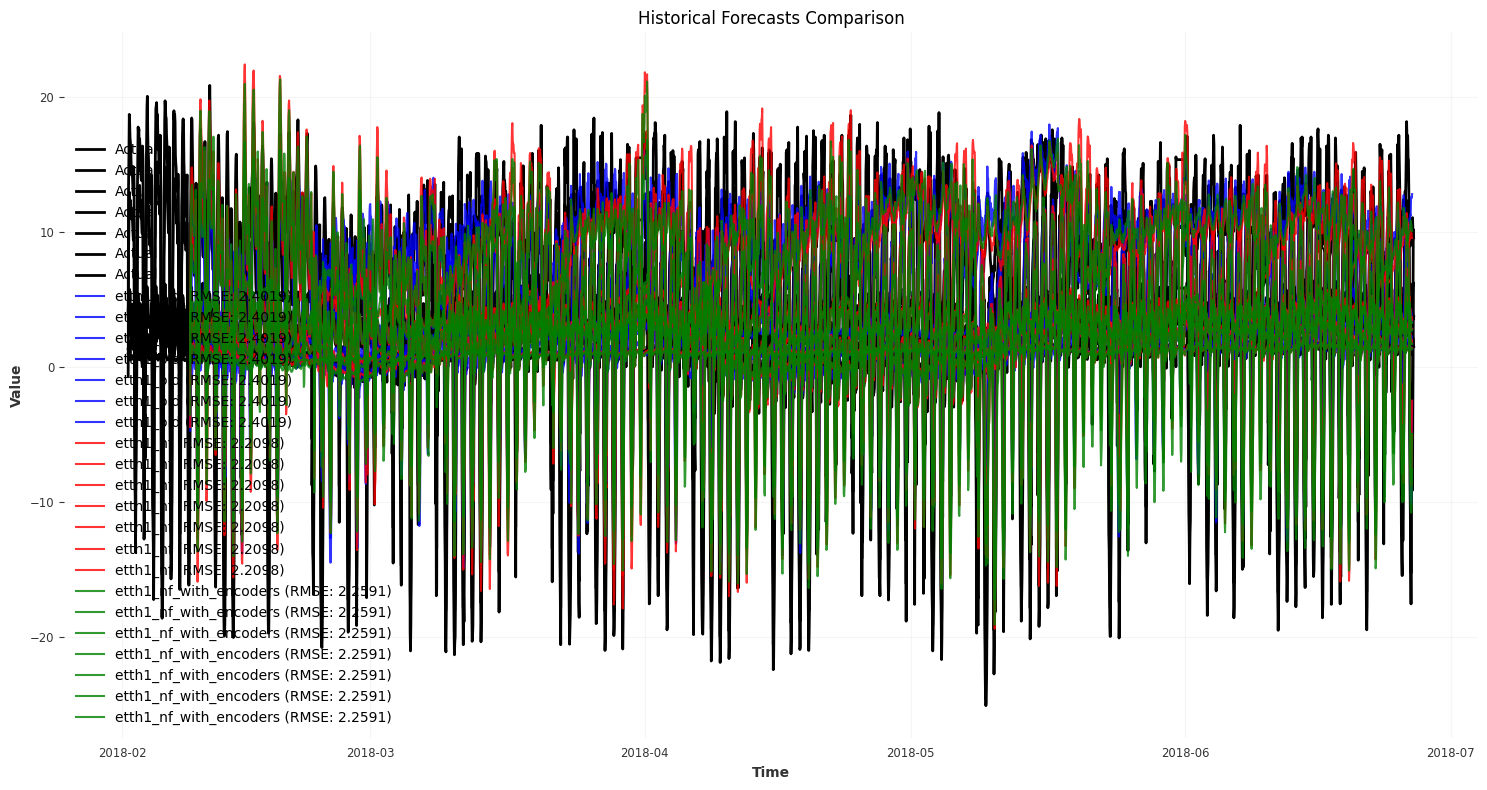


Metrics Comparison Table:
                            RMSE      SMAPE
etth1_old               2.401876  48.019341
etth1_nf                2.209753  41.487610
etth1_nf_with_encoders  2.259138  44.005390


In [28]:
from darts.metrics import smape
from darts.timeseries import concatenate

forecasts = {}
best_model1 = BlockRNNModel.load_from_checkpoint("etth1_old", best=True)
best_model2 = BlockRNNModel.load_from_checkpoint("etth1_nf", best=True)
best_model3 = BlockRNNModel.load_from_checkpoint("etth1_nf_with_encoders", best=True)

best_models = {
    "etth1_old": best_model1,
    "etth1_nf": best_model2,
    "etth1_nf_with_encoders": best_model3,
}
for model_name, model in best_models.items():
    print(f"Generating historical forecasts for {model_name}...")
    forecasts[model_name] = historical_forecasts(model)

actual_test = scaler.inverse_transform(test)

fig, axes = plt.subplots(len(best_models), 1, figsize=(15, 5 * len(best_models)))
if len(best_models) == 1:
    axes = [axes]

colors = ["blue", "red", "green", "orange", "purple"]
metrics_results = {}

for i, (model_name, forecast) in enumerate(forecasts.items()):
    rmse_score = rmse(actual_test, forecast)
    smape_score = smape(actual_test, forecast)

    metrics_results[model_name] = {"RMSE": rmse_score, "SMAPE": smape_score}

    axes[i].plot(
        actual_test.time_index,
        actual_test.values(),
        label="Actual",
        color="black",
        linewidth=2,
    )
    axes[i].plot(
        forecast.time_index,
        forecast.values(),
        label=f"Forecast - {model_name}",
        color=colors[i],
        linewidth=1.5,
    )

    axes[i].set_title(
        f"{model_name} - RMSE: {rmse_score:.4f}, SMAPE: {smape_score:.4f}"
    )
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Value")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("METRICS SUMMARY")
print("=" * 50)
for model_name, metrics in metrics_results.items():
    print(f"{model_name}:")
    print(f"  RMSE: {metrics['RMSE']:.6f}")
    print(f"  SMAPE: {metrics['SMAPE']:.6f}")
    print("-" * 30)

plt.figure(figsize=(15, 8))
plt.plot(
    actual_test.time_index,
    actual_test.values(),
    label="Actual",
    color="black",
    linewidth=2,
)

for i, (model_name, forecast) in enumerate(forecasts.items()):
    plt.plot(
        forecast.time_index,
        forecast.values(),
        label=f"{model_name} (RMSE: {metrics_results[model_name]['RMSE']:.4f})",
        color=colors[i],
        linewidth=1.5,
        alpha=0.8,
    )

plt.title("Historical Forecasts Comparison")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame(metrics_results).T
print("\nMetrics Comparison Table:")
print(metrics_df.round(6))